In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import QuantileTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
traffic_df = pd.read_csv('/content/Traffic.csv')
traffic_two_month_df = pd.read_csv('/content/TrafficTwoMonth.csv')

In [ ]:
traffic_df['Traffic Situation'].value_counts()

,count
Traffic Situation,
normal,1669
heavy,682
high,321
low,304


In [ ]:
traffic_df['Source'] = 'OneMonth'
traffic_two_month_df['Source'] = 'TwoMonth'
combined_df = pd.concat([traffic_df, traffic_two_month_df], ignore_index=True)

In [ ]:
# 1. Distribution of vehicle counts for cars, bikes, buses, and trucks
fig = make_subplots(rows=2, cols=2, subplot_titles=("Car Counts", "Bike Counts", "Bus Counts", "Truck Counts"))

fig.add_trace(go.Histogram(x=combined_df['CarCount'], name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Histogram(x=combined_df['BikeCount'], name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Histogram(x=combined_df['BusCount'], name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Histogram(x=combined_df['TruckCount'], name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Distribution of Vehicle Counts', title_x=0.5, showlegend=False, template='plotly_white')
fig.update_xaxes(title_text="Count")
fig.update_yaxes(title_text="Frequency")
fig.show()

In [ ]:
# 3. Distribution of traffic situations
fig = px.pie(combined_df, names='Traffic Situation', title='Traffic Situation Distribution', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title_text='Traffic Situation Distribution', title_x=0.5, template='plotly_white')
fig.show()

In [ ]:
# 4. Vehicle count vary by day of the week
fig = make_subplots(rows=2, cols=2, subplot_titles=("Car Counts by Day", "Bike Counts by Day", "Bus Counts by Day", "Truck Counts by Day"))

fig.add_trace(go.Box(x=combined_df['Day of the week'], y=combined_df['CarCount'], name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Box(x=combined_df['Day of the week'], y=combined_df['BikeCount'], name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Box(x=combined_df['Day of the week'], y=combined_df['BusCount'], name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Box(x=combined_df['Day of the week'], y=combined_df['TruckCount'], name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Vehicle Counts by Day of the Week', title_x=0.5, showlegend=False, template='plotly_white')
fig.update_xaxes(title_text="Day of the Week")
fig.update_yaxes(title_text="Count")
fig.show()

In [ ]:
# 12. Traffic situation distribution by day of the week
fig = px.box(combined_df, x='Day of the week', y='Traffic Situation', title='Traffic Situation by Day of the Week', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title_text='Traffic Situation by Day of the Week', title_x=0.5, xaxis_title='Day of the Week', yaxis_title='Traffic Situation', template='plotly_white')
fig.show()

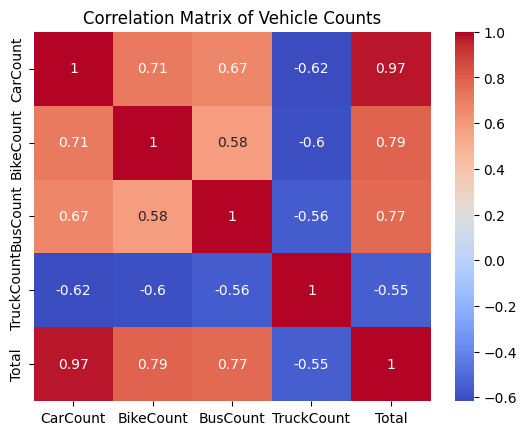

In [ ]:
# 13. Correlations between different vehicle types
corr_matrix = combined_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Vehicle Counts')
plt.show()

In [ ]:
# Identify and remove outliers
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

vehicle_counts = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']
combined_df = remove_outliers(combined_df, vehicle_counts)

In [ ]:
# Check for missing values and duplicates
print("Missing values in each column:")
print(combined_df.isnull().sum())

print(f"Number of duplicate rows: {combined_df.duplicated().sum()}")

Missing values in each column:
Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
Source               0
Hour                 0
dtype: int64
Number of duplicate rows: 0


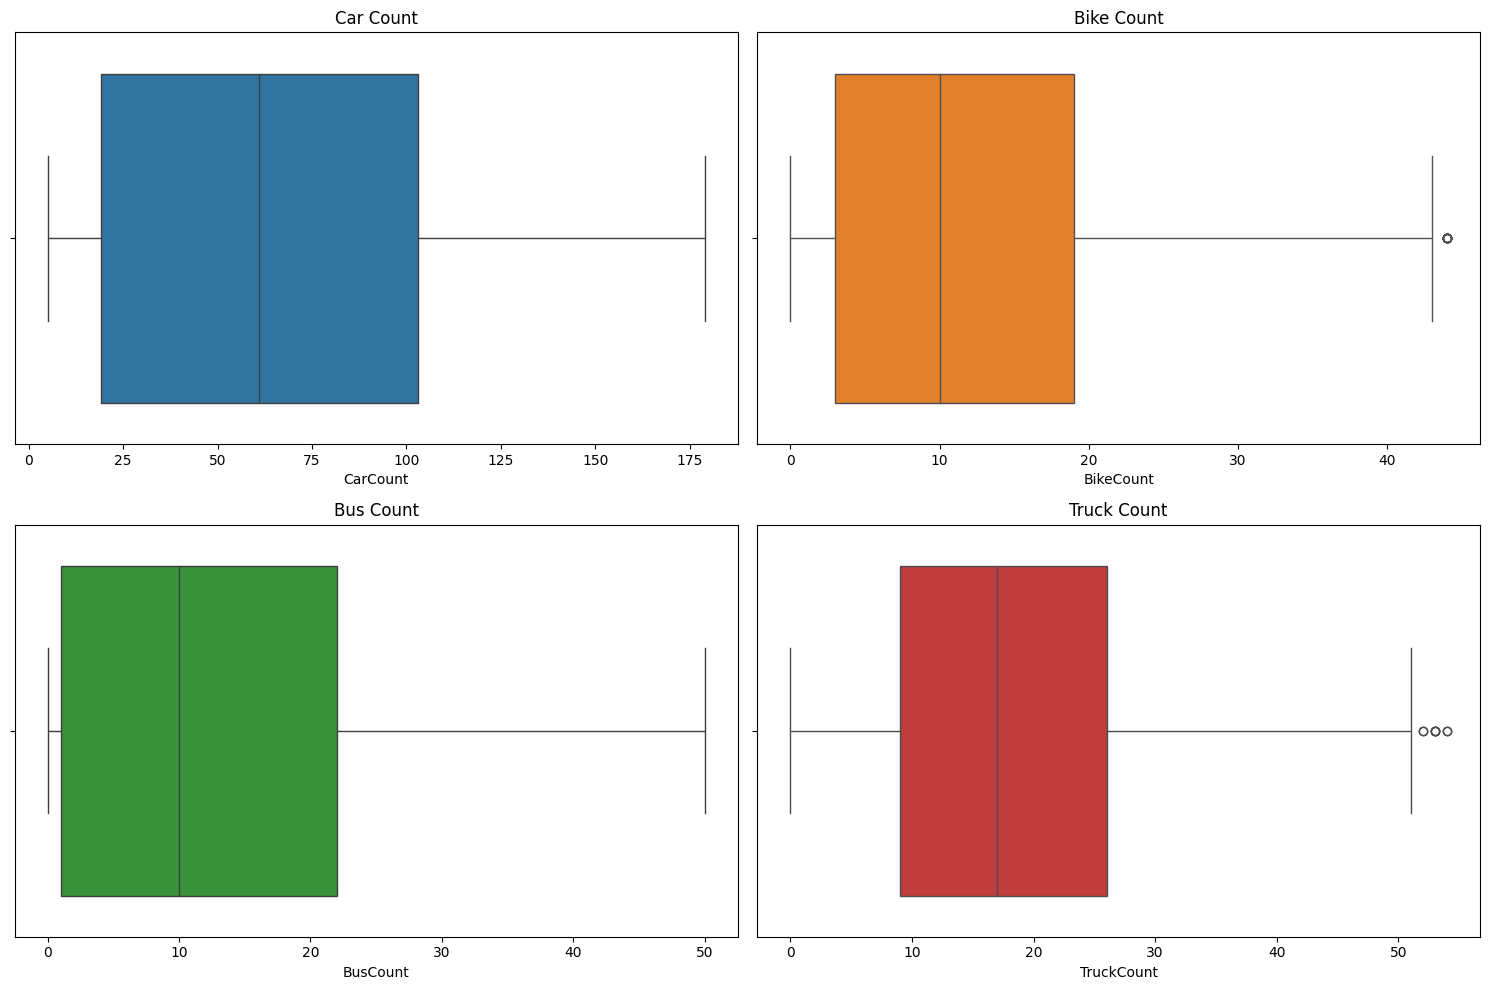

In [ ]:
# Plot boxplots to visualize outliers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(data=combined_df, x='CarCount', ax=axes[0, 0], color='#1f77b4')
sns.boxplot(data=combined_df, x='BikeCount', ax=axes[0, 1], color='#ff7f0e')
sns.boxplot(data=combined_df, x='BusCount', ax=axes[1, 0], color='#2ca02c')
sns.boxplot(data=combined_df, x='TruckCount', ax=axes[1, 1], color='#d62728')
axes[0, 0].set_title('Car Count')
axes[0, 1].set_title('Bike Count')
axes[1, 0].set_title('Bus Count')
axes[1, 1].set_title('Truck Count')
plt.tight_layout()
plt.show()

In [ ]:
# Check normality for each vehicle count before normalization
def check_normality(data):
    stat, p = shapiro(data)
    return p > 0.05

print("Normality check before normalization:")
car_normal = check_normality(combined_df['CarCount'])
bike_normal = check_normality(combined_df['BikeCount'])
bus_normal = check_normality(combined_df['BusCount'])
truck_normal = check_normality(combined_df['TruckCount'])

print(f"Car count normality: {car_normal}")
print(f"Bike count normality: {bike_normal}")
print(f"Bus count normality: {bus_normal}")
print(f"Truck count normality: {truck_normal}")

# Normalize data using QuantileTransformer
scaler = QuantileTransformer(output_distribution='normal')
combined_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount']] = scaler.fit_transform(combined_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount']])

# Check normality for each vehicle count after normalization
print("Normality check after normalization:")
car_normal = check_normality(combined_df['CarCount'])
bike_normal = check_normality(combined_df['BikeCount'])
bus_normal = check_normality(combined_df['BusCount'])
truck_normal = check_normality(combined_df['TruckCount'])

print(f"Car count normality: {car_normal}")
print(f"Bike count normality: {bike_normal}")
print(f"Bus count normality: {bus_normal}")
print(f"Truck count normality: {truck_normal}")

Normality check before normalization:
Car count normality: False
Bike count normality: False
Bus count normality: False
Truck count normality: False
Normality check after normalization:
Car count normality: False
Bike count normality: False
Bus count normality: False
Truck count normality: False


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8720.

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8720.



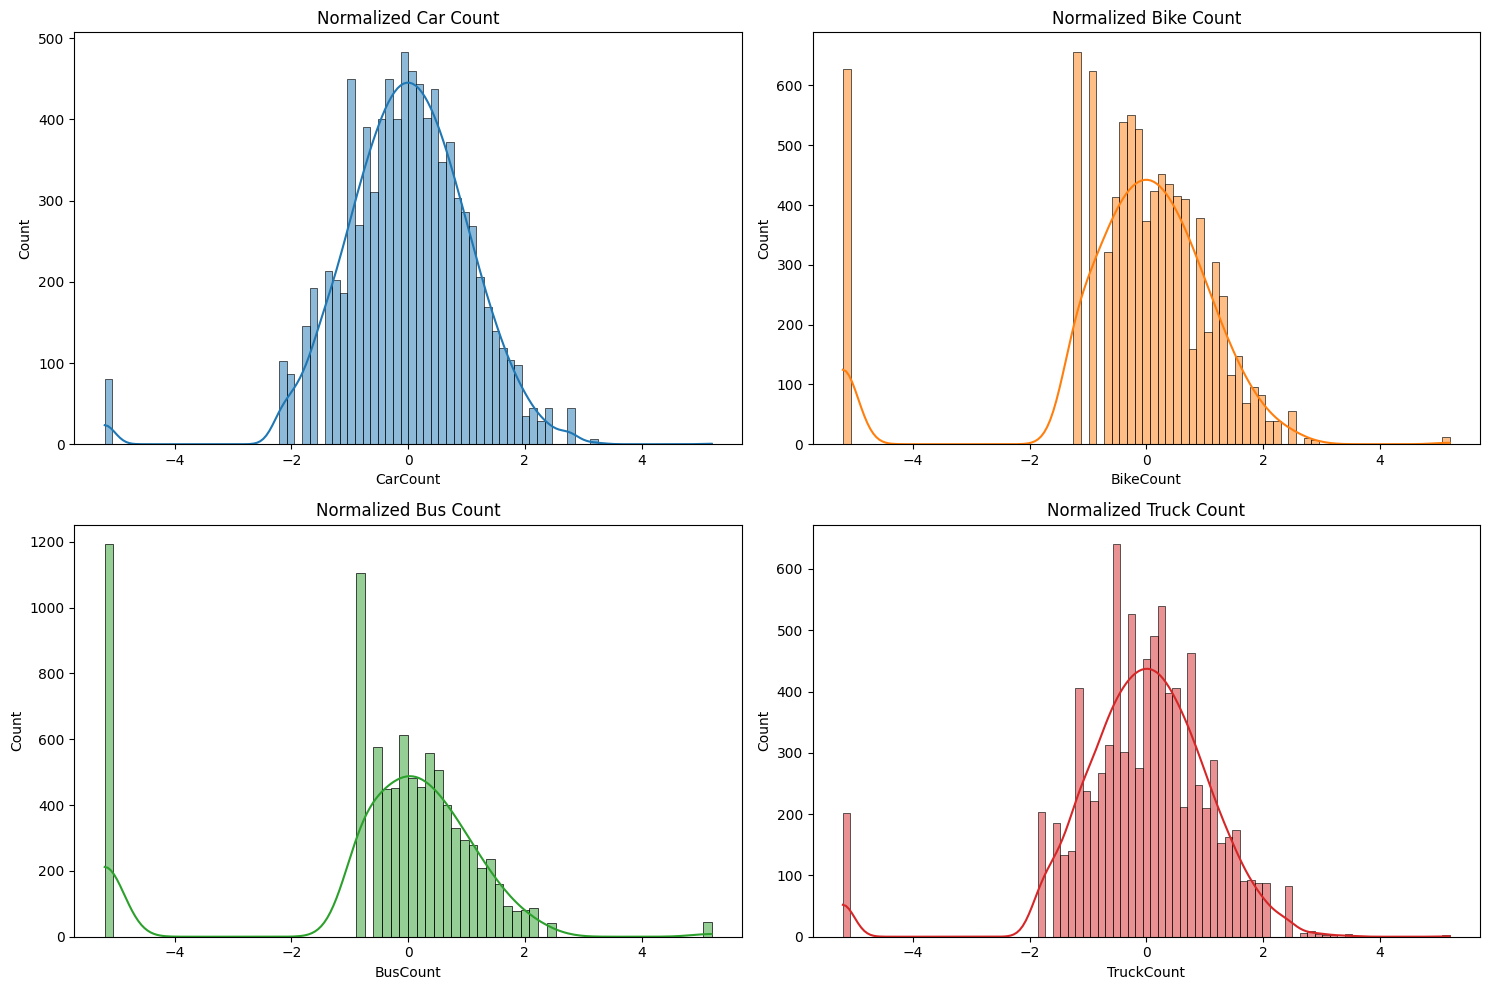

In [ ]:
# Check distribution after normalization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(combined_df['CarCount'], ax=axes[0, 0], kde=True, color='#1f77b4')
sns.histplot(combined_df['BikeCount'], ax=axes[0, 1], kde=True, color='#ff7f0e')
sns.histplot(combined_df['BusCount'], ax=axes[1, 0], kde=True, color='#2ca02c')
sns.histplot(combined_df['TruckCount'], ax=axes[1, 1], kde=True, color='#d62728')
axes[0, 0].set_title('Normalized Car Count')
axes[0, 1].set_title('Normalized Bike Count')
axes[1, 0].set_title('Normalized Bus Count')
axes[1, 1].set_title('Normalized Truck Count')
plt.tight_layout()
plt.show()

In [ ]:
# Prepare the features and target
X = combined_df.drop(columns=['Traffic Situation'])
y = combined_df['Traffic Situation']
#This separation is crucial for training the model, allowing it to learn from the features (X) to predict the target (y).

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Preprocessing pipeline for numeric and categorical features
numeric_features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Hour']
categorical_features = ['Time', 'Date', 'Day of the week', 'Source']

preprocessor = ColumnTransformer(
    =[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])transformers

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Lists of features
numeric_features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Hour']
categorical_features = ['Time', 'Date', 'Day of the week', 'Source']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Standardize numeric features
        ('cat', OneHotEncoder(), categorical_features)  # One-hot encode categorical features
    ]
)


In [ ]:
# Make predictions
y_pred = model.predict(X_test)

NameError: name 'model' is not defined

In [ ]:
y_pred

array(['normal', 'normal', 'heavy', ..., 'normal', 'normal', 'heavy'],
      dtype=object)

In [ ]:
# Evaluate the model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.9919724770642202
Classification Report:
              precision    recall  f1-score   support

       heavy       0.99      1.00      1.00       333
        high       0.98      1.00      0.99       122
         low       1.00      0.96      0.98       238
      normal       0.99      1.00      0.99      1051

    accuracy                           0.99      1744
   macro avg       0.99      0.99      0.99      1744
weighted avg       0.99      0.99      0.99      1744



In [ ]:
# Make predictions on the test dataset
y_pred = model.predict(X_test)

# Combine predictions with actual test data
output_df = X_test.copy()
output_df['Actual Traffic Situation'] = y_test
output_df['Predicted Traffic Situation'] = y_pred

# Save the output to a CSV file
output_df.to_csv('traffic_predictions_output.csv', index=False)

print("Predictions saved to 'traffic_predictions_output.csv'")


Predictions saved to 'traffic_predictions_output.csv'


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

array(['normal', 'normal', 'heavy', ..., 'normal', 'normal', 'heavy'],
      dtype=object)